In [35]:
%matplotlib inline
import cosima_cookbook as cc
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, shiftgrid
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean as cm
import cartopy
import cartopy.crs as ccrs
import pandas as pd
import copy
import math
from collections import OrderedDict
import IPython.display
# import seaborn as sns
from glob import glob
from tqdm import tqdm_notebook
import IPython.display
import cmocean as cm
from scipy.io import loadmat
from dask.distributed import Client
import cartopy.crs as ccrs
import cartopy.feature as cft
import matplotlib.ticker as mticker
import warnings
warnings.filterwarnings('ignore')
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
import matplotlib
import datetime
from datetime import date
#print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

In [3]:
figdir = ''
NOSYNC = 'NOSYNC/' # where to save figs we don't want to sync
if not os.path.exists(NOSYNC):
    os.makedirs(NOSYNC)
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    #plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

In [6]:
land=cft.NaturalEarthFeature('physical','land','110m',
                            edgecolor='black',facecolor='gray',
                            linewidth=0.5)

font={'family':'normal',
       'weight':'bold',
        'size':16}
matplotlib.rc('font',**font)

In [6]:
#PV_DS.to_netcdf('PV_DS_whole10yr_Ksh')
#PV_DS_mean.to_netcdf('PV_DS_mean10yr_Ksh')
#PV_var.to_netcdf('PV_DS_var10yr_Ksh')

In [13]:
PV_DS=xr.open_dataarray('PV_DS_whole10yr_Ksh')
PV_DS_mean=xr.open_dataarray('PV_DS_mean10yr_Ksh')
PV_var=xr.open_dataarray('PV_DS_var10yr_Ksh')

In [7]:
WBC=OrderedDict([
    ('eac', {'region':[145-360,174-360,-48,-20], 'x':slice(145-360,174-360),
                    'y': slice(-48,-20)}),
    ('gs',  {'region':[-82,-62,22,46], 'x':slice(-82,-62),
                    'y': slice(22,46)}),
    ('kc',  {'region':[130-360,155-360,28,45], 'x':slice(130-360,155-360),
                    'y': slice(28,45)})
])

# Downstream potential vorticity 

In [8]:
def input_pv(time):
    print('loading u...')
    u = cc.get_nc_variable(expt,'ocean.nc','u',use_cache=True,
                                 n=n_files,time_units=time_units,offset=offset)\
                                 .sel(xu_ocean=kcx)\
                                 .sel(yu_ocean=kcy)\
                                 .sel(time=time)
    print('loading v...')
    v = cc.get_nc_variable(expt,'ocean.nc','v',use_cache=True,
                                 n=n_files,time_units=time_units,offset=offset)\
                                 .sel(xu_ocean=kcx)\
                                 .sel(yu_ocean=kcy)\
                                 .sel(time=time)
    print('loading w...')
    w=cc.get_nc_variable(expt,'ocean.nc','wt',use_cache=True,
                                 n=n_files,time_units=time_units,offset=offset)\
                                 .sel(xt_ocean=kcx)\
                                 .sel(yt_ocean=kcy)\
                                 .sel(time=time)
    print('loading pv...')
    pv = cc.get_nc_variable(expt,'ocean.nc','vert_pv',use_cache=True,
                                 n=n_files,time_units=time_units,offset=offset)\
                                 .sel(xt_ocean=kcx)\
                                 .sel(yt_ocean=kcy)\
                                 .sel(time=time)
    return u,v,w,pv

In [9]:
warnings.filterwarnings('ignore')
ekey='01deg'
expt=exptdata.exptdict[ekey]['expt']
n_files = exptdata.exptdict[ekey]['n_files']
time_units = exptdata.exptdict[ekey]['time_units']
offset = exptdata.exptdict[ekey]['offset']

region=WBC['kc']['region']
kcx=WBC['kc']['x']
kcy=WBC['kc']['y']

time=slice('1999-01-01','2009-01-01')
u,v,w,pv=input_pv(time)

loading u...
Reading from cache file cache_get_nc_variable_01deg_jra55v13_iaf_ocean.nc_u_None_days-since-0001-01-01_None_False.pkl
loading v...
Reading from cache file cache_get_nc_variable_01deg_jra55v13_iaf_ocean.nc_v_None_days-since-0001-01-01_None_False.pkl
loading w...
Reading from cache file cache_get_nc_variable_01deg_jra55v13_iaf_ocean.nc_wt_None_days-since-0001-01-01_None_False.pkl
loading pv...
Reading from cache file cache_get_nc_variable_01deg_jra55v13_iaf_ocean.nc_vert_pv_None_days-since-0001-01-01_None_False.pkl


## Whole PV
\begin{equation}
\overline{\textbf{u}\cdot\nabla q}=\overline{u\frac{\partial q}{\partial x}+ v \frac{\partial q}{\partial y}+w \frac{\partial q}{\partial z}}
\end{equation}

In [10]:
def whole_pv(u,v,w,pv):
    # load and trim grid data
    zsize=pv.shape[1]
    ysize=pv.shape[2]
    xsize=pv.shape[3]
    grid = xr.open_dataset('/g/data3/hh5/tmp/cosima/access-om2-01/01deg_jra55v13_iaf/output120/ocean/ocean_grid.nc')
    dxu=grid.dxu.sel(xu_ocean=kcx)\
            .sel(yu_ocean=kcy)[:,1:]
    dxdx=dxu.values[:,0:-1]+dxu.values[:,1:]
    dxdx_snmean=1/2*(dxdx[0:-1,:]+dxdx[1:,:])
    dx3d=np.tile(dxdx_snmean,(zsize,1,1))

    dyu=grid.dyu.sel(xu_ocean=kcx)\
            .sel(yu_ocean=kcy)[1:,:]
    dydy=dyu.values[0:-1,:]+dyu.values[1:,:]
    dy_wemean=1/2*(dydy[:,0:-1]+dydy[:,1:])
    dy3d=np.tile(dy_wemean,(zsize,1,1))  

    z=pv.st_ocean.values
    dz=z[1:]-z[0:-1]
    dzdz=dz[1:]+dz[0:-1]
    dz3d=np.tile(dzdz,(ysize-2,xsize-2,1))
    dz3d=np.transpose(dz3d,(2,0,1))
    pv_ds=np.zeros((zsize-2,ysize-2,xsize-2))
    T=len(u.time)
    for i in range(0,T):
        print('opening file',str(i+1),'in',str(T))
        u1=u.isel(time=i)
        v1=v.isel(time=i)
        w1=w.isel(time=i)
        pv1=pv.isel(time=i)
        
        #u*(dq/dx)
        dq=pv1.values[:,0:-1,2:]-pv1.values[:,0:-1,0:-2]
        unew=u1[:,:,1:]
        uu=1/2*(unew.values[:,:,0:-1]+unew.values[:,:,1:])
        uu_snmean=1/2*(uu[:,0:-1,:]+uu[:,1:,:])
        udq_dx=uu_snmean*(dq/dx3d)
        Udq_dx=xr.DataArray(udq_dx,coords=[pv1['st_ocean'],
                                           pv1['yt_ocean'][0:-1],pv1['xt_ocean'][1:-1]])
        #v*(dq/dy)
        pvy=pv1[:,:,0:-1]
        dqy=pvy.values[:,2:,:]-pvy.values[:,0:-2,:]
        vnew=v1[:,1:,:]
        vv=1/2*(vnew.values[:,0:-1,:]+vnew.values[:,1:,:])
        vv_wemean=1/2*(vv[:,:,0:-1]+vv[:,:,1:])
        vdq_dy=vv_wemean*(dqy/dy3d)
        Vdq_dy=xr.DataArray(vdq_dy,coords=[pv1['st_ocean'],
                                           pv1['yt_ocean'][1:-1],pv1['xt_ocean'][0:-1]])
        #w*(dq/dz)
        wnew=w1[:,1:-1,1:-1]
        qz=pv1[:,1:-1,1:-1]
        dqz=qz.values[0:-2,:,:]-qz.values[2:,:,:]
        w_mean=1/2*(wnew.values[0:-1,:,:]+wnew.values[1:,:,:])
        wdq_dz=w_mean[0:-1,:,:]*(dqz/dz3d)
        Wdq_dz=xr.DataArray(wdq_dz,coords=[qz['st_ocean'][1:-1],qz['yt_ocean'],qz['xt_ocean']])
        #speed=np.sqrt(uu_snmean**2+vv_wemean[:,:,1:]**2)
        pv_downstream=(Udq_dx+Vdq_dy+Wdq_dz)#/speed[0:-1,:,:]
        pv_ds=pv_ds+pv_downstream.values/T
    PV_DS=xr.DataArray(pv_ds,coords=[pv1['st_ocean'][1:-1],pv1['yt_ocean'][1:-1],pv1['xt_ocean'][1:-1]])
    return PV_DS

In [12]:
PV_DS=whole_pv(u,v,w,pv)

Text(0, 0.5, 'S$^{-3}$')

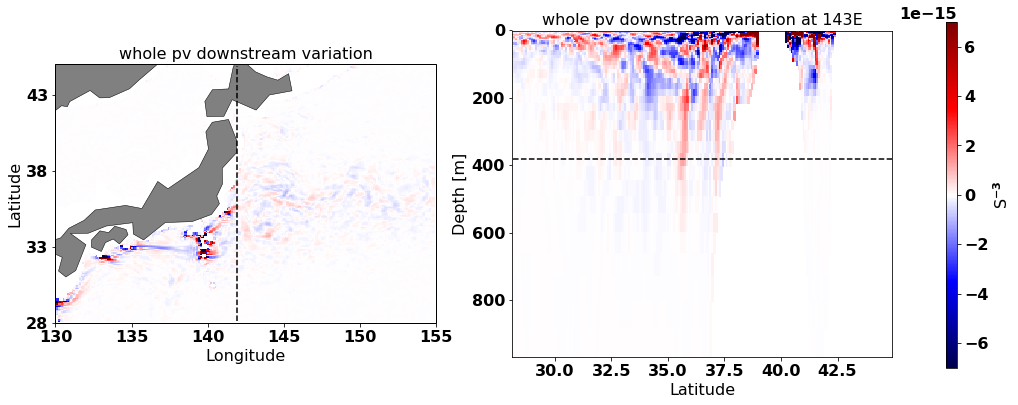

In [24]:
d=400
fig=plt.figure(figsize=(15,6))

z1=PV_DS.sel(st_ocean=d,method='nearest').st_ocean.values
x1=PV_DS.sel(xt_ocean=142-360,method='nearest').xt_ocean.values+360
z=PV_DS.st_ocean.values
y=PV_DS.yt_ocean.values

ax=plt.subplot(1,2,1,projection=ccrs.PlateCarree())
ax.add_feature(land)
ax.set_extent(region,crs=ccrs.PlateCarree())
ax.set_xticks(np.arange(kcx.start,kcx.stop+1,5)+360,crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(kcy.start,kcy.stop+1,5),crs=ccrs.PlateCarree())
p1=PV_DS.sel(st_ocean=d,method='nearest').sel(xt_ocean=kcx).sel(yt_ocean=kcy).plot(cmap='seismic',vmin=-7e-15,vmax=7e-15,add_colorbar=False)
plt.plot(np.tile(x1,len(y)),y,'k--')
plt.ylabel('Latitude',fontsize=16)
plt.xlabel('Longitude',fontsize=16)
plt.title('')
plt.title('whole pv downstream variation',fontsize=16)

ax=plt.subplot(1,2,2)
PV_DS.sel(xt_ocean=142-360,method='nearest').sel(st_ocean=slice(0,1000)).plot(cmap='seismic',vmin=-7e-15,vmax=7e-15,yincrease=False,add_colorbar=False)
plt.plot(y,np.tile(z1,len(y)),'k--')
plt.ylabel('Depth [m]',fontsize=16)
plt.xlabel('Latitude',fontsize=16)
plt.title('')
plt.title('whole pv downstream variation at 143E',fontsize=16)


ax3 = plt.axes([0.95,0.1,0.01,0.8])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('S$^{-3}$',fontsize=16)

In [15]:
U10=u.mean('time')
V10=v.mean('time')
U10_sl=U10.sel(st_ocean=400,method='nearest')
V10_sl=V10.sel(st_ocean=400,method='nearest')
X,Y=np.meshgrid(U10_sl['xu_ocean'].values+360,V10_sl['yu_ocean'].values)

Text(0, 0.5, 'Latitude')

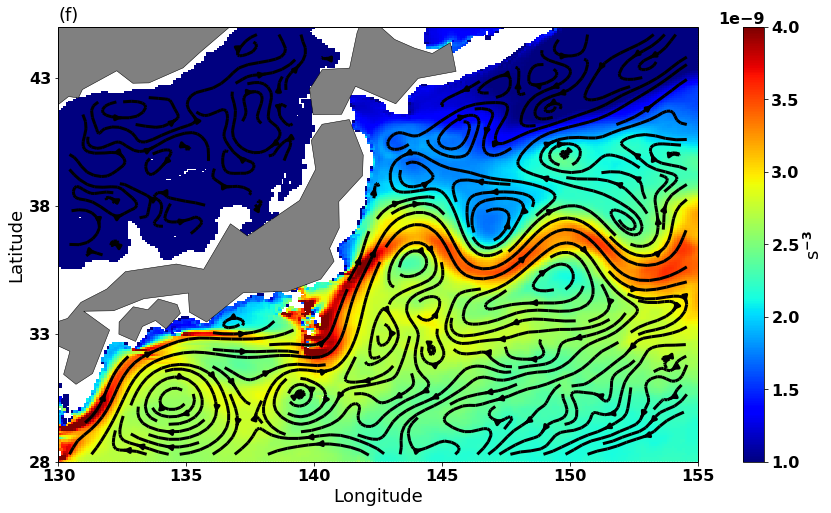

In [18]:
warnings.filterwarnings('ignore')
d=400
fig=plt.figure(figsize=(16,8))
ax0=fig.add_subplot(1,1,1,projection=ccrs.PlateCarree())
ax0.set_extent(region, crs=ccrs.PlateCarree())
ax0.add_feature(land)
ax0.streamplot(X, Y, U10_sl.values, V10_sl.values,density=2,color='k',linewidth=3)
ax0.set_xticks(np.arange(kcx.start,kcx.stop+1,5)+360, crs=ccrs.PlateCarree())
ax0.set_yticks(np.arange(kcy.start,kcy.stop+1,5), crs=ccrs.PlateCarree())
p=pv.mean('time').sel(st_ocean=d,method='nearest').plot(cmap='jet'
                                                          ,vmin=1e-9,vmax=4e-9,add_colorbar=False)
cb=plt.colorbar(p)
cb.ax.set_ylabel('s$^{-3}$',fontsize=18)
plt.title('')
plt.title('(f)',loc='left',fontsize=18)
plt.xlabel('Longitude',fontsize=18)
plt.ylabel('Latitude',fontsize=18)
#savefigure('pvandsl_ksh01')

## Downstream pv (mean flow)
\begin{equation}
\overline{\textbf{u}}\cdot\nabla \overline{q}=\overline{u}\frac{\partial \overline{q}}{\partial x}+\overline{v}\frac{\partial\overline{q}}{\partial y}+\overline{w}\frac{\partial \overline{q}}{\partial z}
\end{equation}

In [25]:
def meands_pv_mf(u,v,w,pv):
    zsize=pv.shape[1]
    ysize=pv.shape[2]
    xsize=pv.shape[3]
    u=u.mean('time')
    v=v.mean('time')
    w=w.mean('time')
    pv=pv.mean('time')
    grid = xr.open_dataset('/g/data3/hh5/tmp/cosima/access-om2-01/01deg_jra55v13_iaf/output120/ocean/ocean_grid.nc')
    dxu=grid.dxu.sel(xu_ocean=kcx)\
            .sel(yu_ocean=kcy)[:,1:]
    dxdx=dxu.values[:,0:-1]+dxu.values[:,1:]
    dxdx_snmean=1/2*(dxdx[0:-1,:]+dxdx[1:,:])
    dx3d=np.tile(dxdx_snmean,(zsize,1,1))

    dyu=grid.dyu.sel(xu_ocean=kcx)\
            .sel(yu_ocean=kcy)[1:,:]
    dydy=dyu.values[0:-1,:]+dyu.values[1:,:]
    dy_wemean=1/2*(dydy[:,0:-1]+dydy[:,1:])
    dy3d=np.tile(dy_wemean,(zsize,1,1))  

    z=pv.st_ocean.values
    dz=z[1:zsize]-z[0:-1]
    dzdz=dz[1:]+dz[0:-1]
    dz3d=np.tile(dzdz,(ysize-2,xsize-2,1))
    dz3d=np.transpose(dz3d,(2,0,1))
    
    #u*(dq/dx)
    dq=pv.values[:,0:-1,2:]-pv.values[:,0:-1,0:-2]
    unew=u[:,:,1:]
    uu=1/2*(unew.values[:,:,0:-1]+unew.values[:,:,1:])
    uu_snmean=1/2*(uu[:,0:-1,:]+uu[:,1:,:])
    udq_dx=uu_snmean*(dq/dx3d)
    Udq_dx=xr.DataArray(udq_dx,coords=[pv['st_ocean'],pv['yt_ocean'][0:-1],pv['xt_ocean'][1:-1]])
    #v*(dq/dy)
    pvy=pv[:,:,0:-1]
    dqy=pvy.values[:,2:,:]-pvy.values[:,0:-2,:]
    vnew=v[:,1:,:]
    vv=1/2*(vnew.values[:,0:-1,:]+vnew.values[:,1:,:])
    vv_wemean=1/2*(vv[:,:,0:-1]+vv[:,:,1:])
    vdq_dy=vv_wemean*(dqy/dy3d)
    Vdq_dy=xr.DataArray(vdq_dy,coords=[pv['st_ocean'],pv['yt_ocean'][1:-1],pv['xt_ocean'][0:-1]])
    #w*(dq/dz)
    wnew=w[:,1:-1,1:-1]
    qz=pv[:,1:-1,1:-1]
    dqz=qz.values[0:-2,:,:]-qz.values[2:,:,:]
    w_mean=1/2*(wnew.values[0:-1,:,:]+wnew.values[1:,:,:])
    wdq_dz=w_mean[0:-1,:,:]*(dqz/dz3d)
    Wdq_dz=xr.DataArray(wdq_dz,coords=[qz['st_ocean'][1:-1],qz['yt_ocean'],qz['xt_ocean']])
    #speed=np.sqrt(uu_snmean[:,1:-1,:]**2+vv_wemean[:,:,1:]**2)
    pv_downstream=(Udq_dx+Vdq_dy+Wdq_dz)#/speed[0:-1,:,:]
    #speed=np.sqrt(uu_snmean**2+vv_wemean[:,:,1:]**2)

    PV_DS_mean=xr.DataArray(pv_downstream,coords=[pv['st_ocean'][1:-1],pv['yt_ocean'][1:-1],pv['xt_ocean'][1:-1]])
    return PV_DS_mean

In [26]:
PV_DS_mean=meands_pv_mf(u,v,w,pv)

Text(0, 0.5, 'S$^{-3}$')

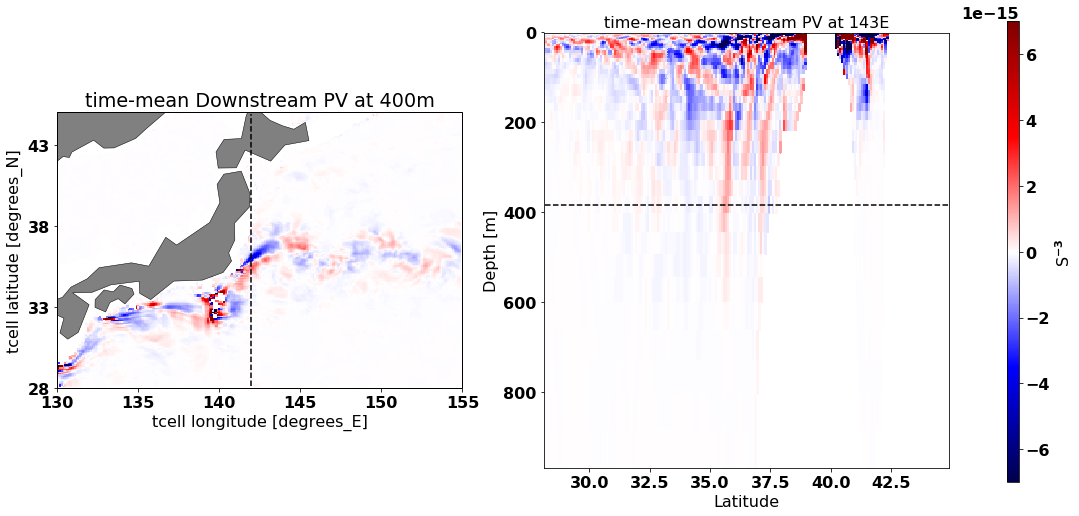

In [28]:
fig=plt.figure(figsize=(16,8))
ax0=fig.add_subplot(1,2,1,projection=ccrs.PlateCarree())
ax0.set_extent(region, crs=ccrs.PlateCarree())
ax0.add_feature(land)
#ax0.streamplot(X, Y, U10_sl.values, V10_sl.values,density=2,color='k',linewidth=3)
ax0.set_xticks(np.arange(kcx.start,kcx.stop+1,5)+360, crs=ccrs.PlateCarree())
ax0.set_yticks(np.arange(kcy.start,kcy.stop+1,5), crs=ccrs.PlateCarree())
PV_DS_mean.sel(st_ocean=d,method='nearest').plot(cmap='seismic',vmin=-7e-15,vmax=7e-15,add_colorbar=False)
plt.plot(np.tile(x1,len(y)),y,'k--')
plt.title('time-mean Downstream PV at 400m')

ax=plt.subplot(1,2,2)
PV_DS.sel(xt_ocean=142-360,method='nearest').sel(st_ocean=slice(0,1000)).plot(cmap='seismic',vmin=-7e-15,vmax=7e-15,yincrease=False,add_colorbar=False)
plt.plot(y,np.tile(z1,len(y)),'k--')
plt.ylabel('Depth [m]',fontsize=16)
plt.xlabel('Latitude',fontsize=16)
plt.title('')
plt.title('time-mean downstream PV at 143E',fontsize=16)


ax3 = plt.axes([0.95,0.1,0.01,0.8])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('S$^{-3}$',fontsize=16)

## PV variability
\begin{equation}
\overline{\textbf{u}'\cdot\nabla q'}=\overline{\textbf{u}\cdot\nabla q}-\overline{\textbf{u}}\cdot\nabla\overline{q}
\end{equation}

In [29]:
PV_var=PV_DS-PV_DS_mean

Text(0, 0.5, 'S$^{-3}$')

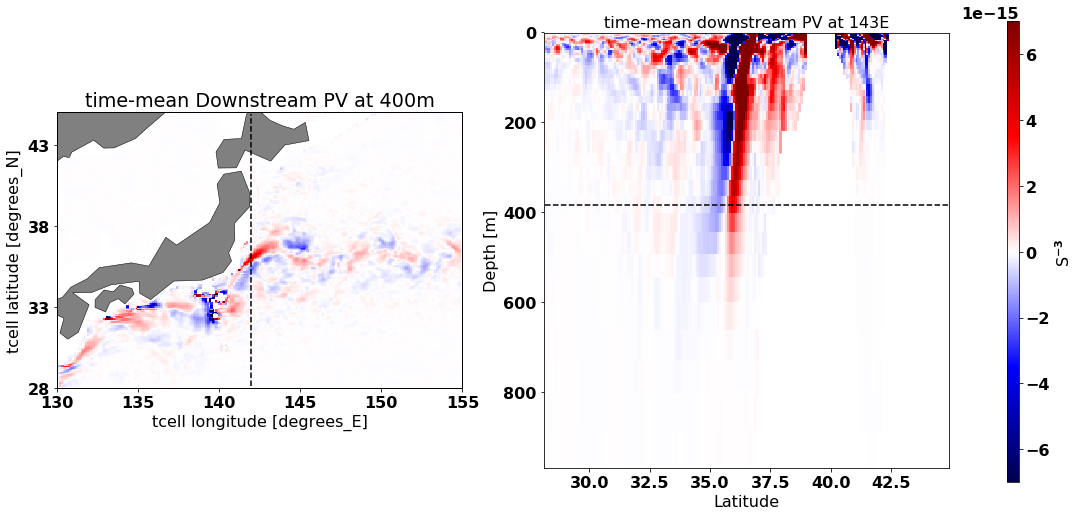

In [30]:
fig=plt.figure(figsize=(16,8))
ax0=fig.add_subplot(1,2,1,projection=ccrs.PlateCarree())
ax0.set_extent(region, crs=ccrs.PlateCarree())
ax0.add_feature(land)
#ax0.streamplot(X, Y, U10_sl.values, V10_sl.values,density=2,color='k',linewidth=3)
ax0.set_xticks(np.arange(kcx.start,kcx.stop+1,5)+360, crs=ccrs.PlateCarree())
ax0.set_yticks(np.arange(kcy.start,kcy.stop+1,5), crs=ccrs.PlateCarree())
PV_var.sel(st_ocean=d,method='nearest').plot(cmap='seismic',vmin=-7e-15,vmax=7e-15,add_colorbar=False)
plt.plot(np.tile(x1,len(y)),y,'k--')
plt.title('time-mean Downstream PV at 400m')

ax=plt.subplot(1,2,2)
PV_var.sel(xt_ocean=142-360,method='nearest').sel(st_ocean=slice(0,1000)).plot(cmap='seismic',vmin=-7e-15,vmax=7e-15,yincrease=False,add_colorbar=False)
plt.plot(y,np.tile(z1,len(y)),'k--')
plt.ylabel('Depth [m]',fontsize=16)
plt.xlabel('Latitude',fontsize=16)
plt.title('')
plt.title('time-mean downstream PV at 143E',fontsize=16)


ax3 = plt.axes([0.95,0.1,0.01,0.8])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('S$^{-3}$',fontsize=16)

### Every 4 year separation $\overline{u}\cdot\overline{q}$

In [31]:
warnings.filterwarnings('ignore')
u = cc.get_nc_variable(expt,'ocean.nc','u',use_cache=True,
                                 n=n_files,time_units=time_units,offset=offset)\
                                 .sel(xu_ocean=kcx)\
                                 .sel(yu_ocean=kcy)
v = cc.get_nc_variable(expt,'ocean.nc','v',use_cache=True,
                             n=n_files,time_units=time_units,offset=offset)\
                             .sel(xu_ocean=kcx)\
                                 .sel(yu_ocean=kcy)
w=cc.get_nc_variable(expt,'ocean.nc','wt',use_cache=True,
                             n=n_files,time_units=time_units,offset=offset)\
                             .sel(xt_ocean=kcx)\
                                 .sel(yt_ocean=kcy)
pv = cc.get_nc_variable(expt,'ocean.nc','vert_pv',use_cache=True,
                             n=n_files,time_units=time_units,offset=offset)\
                             .sel(xt_ocean=kcx)\
                                 .sel(yt_ocean=kcy)

Reading from cache file cache_get_nc_variable_01deg_jra55v13_iaf_ocean.nc_u_None_days-since-0001-01-01_None_False.pkl
Reading from cache file cache_get_nc_variable_01deg_jra55v13_iaf_ocean.nc_v_None_days-since-0001-01-01_None_False.pkl
Reading from cache file cache_get_nc_variable_01deg_jra55v13_iaf_ocean.nc_wt_None_days-since-0001-01-01_None_False.pkl
Reading from cache file cache_get_nc_variable_01deg_jra55v13_iaf_ocean.nc_vert_pv_None_days-since-0001-01-01_None_False.pkl


In [13]:
times = [pd.to_datetime('1985', format='%Y')+pd.DateOffset(years=y) for y in range(0,34,4)]
tranges = list(zip(times[0:-1], times[1:]))
#tranges.append((times[0],times[-1]))  # also include range covering all requested time ranges

yearranges = [str(pd.to_datetime(t[0]).year)+'-'+str(pd.to_datetime(t[1]).year-1) for t in tranges]
tslices = {y:slice(*t) for y,t in zip(yearranges,tranges)}
tsliceall = slice(min(min(tranges)), max(max(tranges))) 

In [34]:
ysize=pv.shape[2]
xsize=pv.shape[3]
grid = xr.open_dataset('/g/data3/hh5/tmp/cosima/access-om2-01/01deg_jra55v13_iaf/output120/ocean/ocean_grid.nc')
dxu=grid.dxu.sel(xu_ocean=slice(130-360, 155-360))\
        .sel(yu_ocean=slice(28,45))[:,1:]
dxdx=dxu.values[:,0:-1]+dxu.values[:,1:]
dxdx_snmean=1/2*(dxdx[0:-1,:]+dxdx[1:,:])
dx3d=np.tile(dxdx_snmean,(75,1,1))

dyu=grid.dyu.sel(xu_ocean=slice(130-360, 155-360))\
        .sel(yu_ocean=slice(28,45))[1:,:]
dydy=dyu.values[0:-1,:]+dyu.values[1:,:]
dy_wemean=1/2*(dydy[:,0:-1]+dydy[:,1:])
dy3d=np.tile(dy_wemean,(75,1,1))  

z=pv.st_ocean.values
dz=z[1:]-z[0:-1]
dzdz=dz[1:]+dz[0:-1]
dz3d=np.tile(dzdz,(ysize-2,xsize-2,1))
dz3d=np.transpose(dz3d,(2,0,1))

In [35]:
def meands_pv_mf(u1,v1,w1,pv1):
    
    u=u1.mean('time')
    v=v1.mean('time')
    w=w1.mean('time')
    pv=pv1.mean('time')
    
    
    #u*(dq/dx)
    dq=pv.values[:,0:-1,2:]-pv.values[:,0:-1,0:-2]
    unew=u[:,:,1:]
    uu=1/2*(unew.values[:,:,0:-1]+unew.values[:,:,1:])
    uu_snmean=1/2*(uu[:,0:-1,:]+uu[:,1:,:])
    udq_dx=uu_snmean*(dq/dx3d)
    Udq_dx=xr.DataArray(udq_dx,coords=[pv['st_ocean'],pv['yt_ocean'][0:-1],pv['xt_ocean'][1:-1]])
    #v*(dq/dy)
    pvy=pv[:,:,0:-1]
    dqy=pvy.values[:,2:,:]-pvy.values[:,0:-2,:]
    vnew=v[:,1:,:]
    vv=1/2*(vnew.values[:,0:-1,:]+vnew.values[:,1:,:])
    vv_wemean=1/2*(vv[:,:,0:-1]+vv[:,:,1:])
    vdq_dy=vv_wemean*(dqy/dy3d)
    Vdq_dy=xr.DataArray(vdq_dy,coords=[pv['st_ocean'],pv['yt_ocean'][1:-1],pv['xt_ocean'][0:-1]])
    #w*(dq/dz)
    wnew=w[:,1:-1,1:-1]
    qz=pv[:,1:-1,1:-1]
    dqz=qz.values[0:-2,:,:]-qz.values[2:,:,:]
    w_mean=1/2*(wnew.values[0:-1,:,:]+wnew.values[1:,:,:])
    wdq_dz=w_mean[0:-1,:,:]*(dqz/dz3d)
    Wdq_dz=xr.DataArray(wdq_dz,coords=[qz['st_ocean'][1:-1],qz['yt_ocean'],qz['xt_ocean']])
    #speed=np.sqrt(uu_snmean[:,1:-1,:]**2+vv_wemean[:,:,1:]**2)
    pv_downstream=(Udq_dx+Vdq_dy+Wdq_dz)#/speed[0:-1,:,:]
    #speed=np.sqrt(uu_snmean**2+vv_wemean[:,:,1:]**2)

    PV_DS_mean=xr.DataArray(pv_downstream,coords=[pv['st_ocean'][1:-1],pv['yt_ocean'][1:-1],pv['xt_ocean'][1:-1]])
    return PV_DS_mean

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


plotting 1 in 8


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


plotting 2 in 8


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


plotting 3 in 8


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


plotting 4 in 8


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


plotting 5 in 8


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


plotting 6 in 8


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


plotting 7 in 8


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


plotting 8 in 8


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


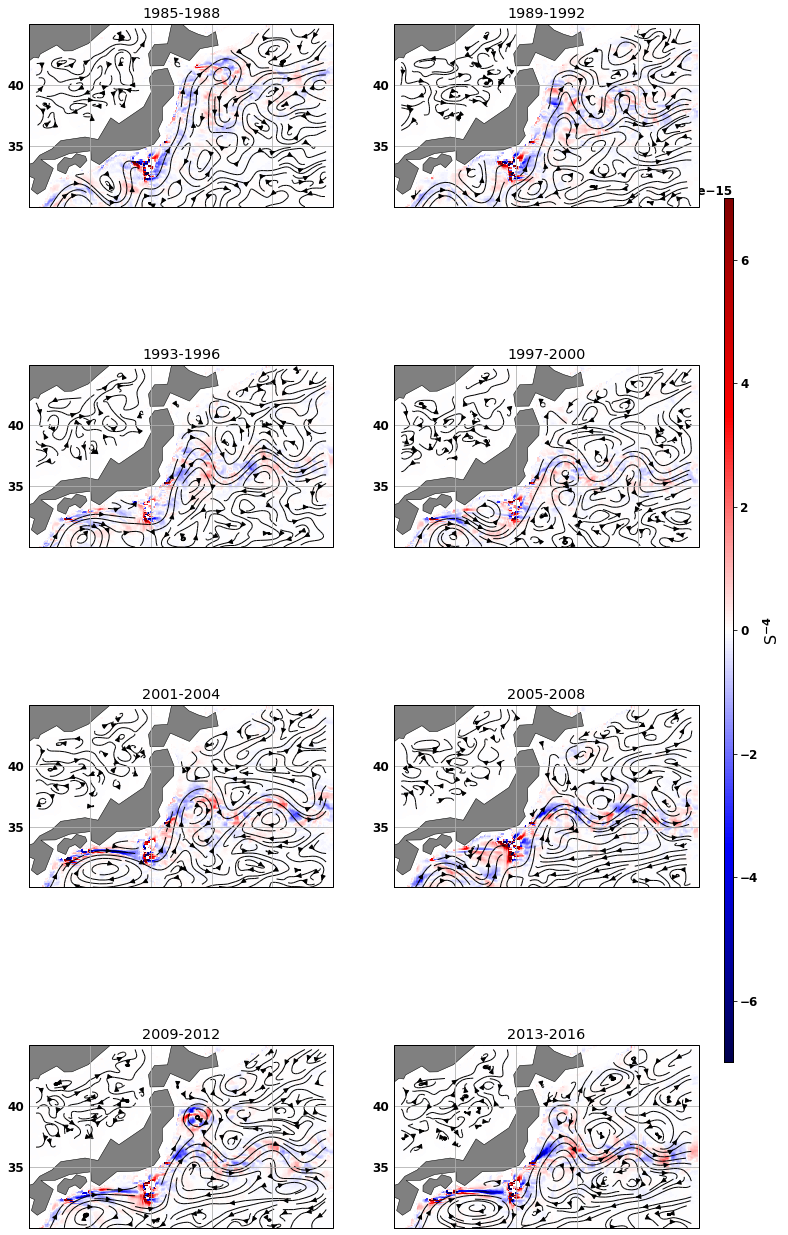

In [37]:
d=400
fig=plt.figure(figsize=(12,24))
#clev=np.arange(-7e-15,7e-15,1e-16)
for i, (yr,t) in enumerate(tslices.items()):
    u1=u.sel(time=t)
    v1=v.sel(time=t)
    w1=w.sel(time=t)
    pv1=pv.sel(time=t)
    PV_DS_mean=meands_pv_mf(u1,v1,w1,pv1)
    U10_sl=u1.mean('time').sel(st_ocean=d,method='nearest')
    V10_sl=v1.mean('time').sel(st_ocean=d,method='nearest')
    X,Y=np.meshgrid(U10_sl['xu_ocean'].values+360,V10_sl['yu_ocean'].values)
    print('plotting',i+1,'in',len(tslices.items()))
    ax=plt.subplot(4,2,i+1,projection=ccrs.PlateCarree())
    ax.add_feature(land)
    ax.set_extent(region,crs=ccrs.PlateCarree())
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
    gl.xlocator = mticker.FixedLocator(range(kcx.start,kcx.stop+1, 5)) 
    gl.ylocator = mticker.FixedLocator(range(kcy.start,kcy.stop+1,5)) 
    gl.xlabels_top = False
    gl.ylabels_right = False
    ax.streamplot(X,Y,U10_sl.values,V10_sl.values,density=1.5,color='k',linewidth=1)
    p1=PV_DS_mean.sel(st_ocean=d,method='nearest').plot(cmap='seismic', vmin=-7e-15,
                                                          vmax=7e-15,add_colorbar=False,
                                                          transform=ccrs.PlateCarree())
    plt.title(yr)
    ax3 = plt.axes([0.93,0.25,0.01,0.5])
    cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
    cb.ax.set_ylabel('S$^{-4}$',fontsize=16)
savefigure('downstreampv_kuroshio')

In [36]:
days=date.toordinal(date(1997,1,1))-date.toordinal(date(1993,1,1))
pvsel=pv.sel(time=slice('1993-01-01','1997-01-01'))

Text(0.5, 1.0, 'pv tendency')

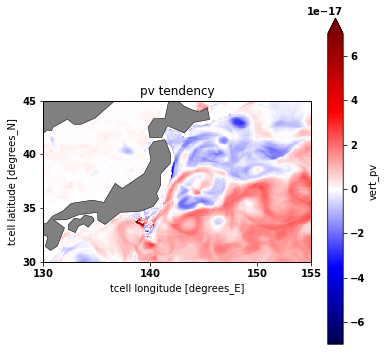

In [37]:
#check pv tendency
pv_diff=(pvsel.isel(time=-1)-pv.isel(time=0)).sel(st_ocean=400,method='nearest')
pv_tend=pv_diff/(days*24*3600)
fig=plt.figure(figsize=(6,6))
ax=plt.subplot(1,1,1,projection=ccrs.PlateCarree())
ax.add_feature(land)
ax.set_extent([130,155, 30,45],crs=ccrs.PlateCarree())
ax.set_xticks([130,140,150,155],crs=ccrs.PlateCarree())
ax.set_yticks([30,35,40,45])
pv_tend.plot(vmin=-7e-17,vmax=7e-17,cmap='seismic')
plt.title('pv tendency')